# Metaplectic Geometrical Optics in 3D - Tracing Rays and Calculating Amplitude

## MGO Solution to Airy Problem

### Setup

In [1]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle

from scipy.integrate import cumulative_trapezoid
from scipy.special import airy
from scipy.signal import find_peaks, argrelextrema
from itertools import product
from gauss_freud_quad import integrate_gauss_freud_quad, get_nodes_and_weights
from scipy.optimize import brentq

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [3]:
from skimage.segmentation import flood

def np_inner_product(a, b):
    return np.einsum('...i,...i->...', a, b)

def np_transpose(A):
    '''return transpose of only the last two dimensions.'''
    return np.moveaxis(A, -1, -2)

def np_eye(shape):
    eye = np.zeros(shape)
    eye[..., :, :] = np.eye(shape[-1])
    return eye

def np_diag(v):
    eye = np_eye((*v.shape, v.shape[-1]))
    return eye * np.stack([v]*v.shape[-1], axis=-1)

def sgn_mask_from_seed(a, seed):
    '''returns boolean array mask for the "sign branch" connected to the seed index.
    A "sign branch" is here defined as a connected region where the sign of the array `a` is constant.
    '''
    return flood(np.signbit(a), seed)

def get_masks_of_const_sgn(a, ND = 3):
    '''returns list of boolean arrays with masks which
    subdivide the values of the array, `a`,
    into regions where the sign is constant.'''
    seed = (0, ) * ND
    regions_remaining = True
    masks = []
    while regions_remaining:
        masks.append(sgn_mask_from_seed(a, seed))
        remaining_cells = np.argwhere(np.any(masks, axis=0) == False)
        if len(remaining_cells) > 0:
            seed = tuple(remaining_cells[0])
        else:
            regions_remaining = False
    return masks

In [4]:
@torch_func
def D(r: ('vector'), k: ('vector'), omega: ('scalar')):
    x, y, z = r
    return - x - inner_product(k, k)

### Exact Solution gives Initial Conditions

In [5]:
def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

x = np.linspace(-8, 0, 1000)
E_ex = Ai(x) # Exact solution is Airy function

# Set ICs from Airy function
first_peak_ind = find_peaks(E_ex)[0][0]
x0  = x[first_peak_ind]
phi0 = E_ex[first_peak_ind]

x1 = x[find_peaks(E_ex)[0][1]]
phi1 = E_ex[find_peaks(E_ex)[0][1]]

In [6]:
x0, phi0, x1, phi1

(-7.375375375375375,
 0.3422883374530224,
 -4.8208208208208205,
 0.3804059912086999)

### Ray Tracing

In [7]:
ND = 3
nt, n2, n3 = 1000, 3, 3

y0s = np.linspace(0, 1, n2)
z0s = np.linspace(0, 10, n3)

rs = np.zeros((nt, n2, n3, 3))
ks = np.zeros((nt, n2, n3, 3))
omega0 = 1.0

# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

for i, y0 in enumerate(y0s):
    for j, z0 in enumerate(z0s):
        tau_ind = (i, j)
        sol = trace_ray(r0 = np.array([x0, y0, z0]), k0=np.array([np.sqrt(-x0), 0, 0]), omega0=omega0, tmin=0, tmax=8, D=D, r_min=np.array([x0, 0, 0]), tsteps=nt)
        sol_nt = len(sol.t)
        rs[:sol_nt, i, j, :] = sol.y[:3].T
        ks[:sol_nt, i, j, :] = sol.y[3:].T
        min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
rs = rs[:min_nt, :, :, :]
ks = ks[:min_nt, :, :, :]
zs = np.concatenate([rs, ks], axis=-1)

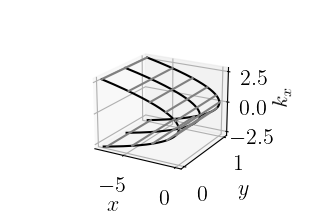

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(projection='3d')
for i, y0 in enumerate(y0s):
    ax.plot(rs[:, i, 0, 0], rs[:, i, 0, 1], ks[:, i, 0, 0], 'k-')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$k_x$')
for i in range(0, len(t), int(len(t)/10)):
    ax.plot(rs[i, :, 0, 0], rs[i, :, 0, 1], ks[i, :, 0, 0], '-', color='grey')
ax.view_init(20, -60, 0)
plt.tight_layout()
plt.savefig('./plots/3D_MGO_airy_dispersion_manifold.png')
plt.savefig('./plots/3D_MGO_airy_dispersion_manifold.pdf')
fig.add_axes([0,0,1,1]).axis("off")
plt.show()

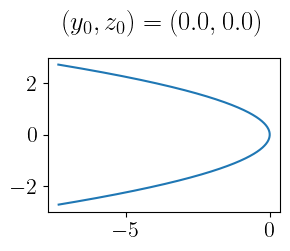

In [9]:
i, j = (0, 0)
plt.figure(figsize=(3,2))
plt.plot(rs[:, 0, 0, 0], ks[:, 0, 0, 0])
plt.title(r'$(y_0, z_0) = (' + str(round(y0s[i], 2)) + ', ' + str(round(z0s[j], 2)) + ')$')
plt.show()

### MGO Part

**Note**: In this numerical implementation, the vector quantities $r$, $k$ (the variables `rs`, `ks` in the code) are written as squeezed row vectors such that they have 3 as their last dimension, and $z=(r, k)$ (the variable `zs` in the code) has 6 as its' last dimension. Thus, the last axis is transposed when compared to Lopez' derivations. However, for convenience, I've chosen to write all matrices from the Lopez-article with the usual shaping. I.e: I have chosen **not** to transpose the matrices. For instance, each *column* in $S^{-1}$ corresponds to either a tangent or normal vector of the dispersion manifold.

In [10]:
def gram_schmidt_orthogonalize(Q):
    N = Q.shape[-1]
    P = np.zeros(Q.shape)

    def norm(A, i):
        norms = np.sqrt(np_inner_product(A[..., i], A[..., i]))
        return np.stack([norms]*A.shape[-1], axis=-1)

    P[..., 0] = Q[..., 0]/norm(Q, 0)
    for k in range(1, N):
        P[..., k] = (Q[..., k]
                        - sum([(
            np.stack([np_inner_product(Q[..., k], P[..., j])]*N, axis=-1)
            ) * P[..., j] for j in range(k)]))
        P[..., k] = P[..., k]/norm(P, k)
    return P

def get_symplectic_tangent_trfm(zs, ND):
    gradt_z = fd.grad(zs, t)
    norms = np.sqrt(np_inner_product(gradt_z, gradt_z))
    T1 = gradt_z/np.stack([norms]*zs.shape[-1], axis=-1) # normalised grad_t z(t, y0, z0)

    # For each tau, create an identity matrix
    eye = np_eye((*zs.shape, zs.shape[-1]))
    
    # For each tau, create orthonormal basis starting from
    # single tangent vector using Gram Schmidt orthogonalization
    ONB = np.copy(eye)
    ONB[..., 0] = T1
    ONB = gram_schmidt_orthogonalize(ONB)

    # Tangent space is first 3 vectors of basis:
    # Note: Basis vectors in T are shaped as columns!
    T = ONB[..., :ND]

    symplJ = np.zeros_like(ONB)
    symplJ[..., :, :] =  np.block([
        [  np.zeros((ND, ND)),  np.eye((ND))        ],
        [  -np.eye(ND),         np.zeros((ND, ND))  ]])
    
    N = -np.matmul(symplJ, T)
    R = np.concatenate((T, N), axis=-1)
    S = np_transpose(R)
    return S

In [11]:
S = get_symplectic_tangent_trfm(zs, ND)
A, B = S[..., :ND, :ND], S[..., :ND, ND:]
gradtau_z = fd.grad(zs, t, y0s, z0s)
Q = np.block([[np_transpose(A)], [np_transpose(B)]])
R = np_transpose(Q) @ gradtau_z

In [12]:
Us, lambs, Vs = np.linalg.svd(B)
Lambdas = np_diag(lambs)
ranks = np.linalg.matrix_rank(B)

eyes = np_eye(A.shape)
eye_rhos = np.copy(eyes)
for i in range(A.shape[-1]):
    eye_rhos[ranks == i, i:, i:] = 0
eye_zetas = eyes - eye_rhos
A_tilde = np_transpose(Us) @ A @ Vs
A_zetas = (np_transpose(eye_zetas) @ A_tilde @ eye_zetas) + eye_rhos
A_rhos = (np_transpose(eye_rhos) @ A_tilde @ eye_rhos) + eye_zetas
Lambda_rhos = (np_transpose(eye_rhos) @ Lambdas @ eye_rhos) + eye_zetas

Nt = (phi0 * np.emath.sqrt(fd.grad(rs[:3, ..., 0], t)[0, ...])
    * np.exp(1j * ( cumulative_trapezoid(np_inner_product(fd.grad(rs, t), ks), t, initial=0, axis=0) ))
    ) / (
    np.emath.power((- 1j * 2*np.pi), (ranks/2)) * (
        np.emath.sqrt(
            np.linalg.det(Lambda_rhos) * np.linalg.det(A_zetas) * np.linalg.det(R)
        )
    )
)

#### Digression: Inspection of Tangent and Normal Vectors and prefactor

In [13]:
print(
    'Check that S has orthosymplectic shape [[A, B], [-B, A]]',
    np.all(np.isclose(S[..., :ND, :ND] - S[..., ND:, ND:], 0)),
    np.all(np.isclose(S[..., :ND, ND:] + S[..., ND:, :ND], 0)),
)

Check that S has orthosymplectic shape [[A, B], [-B, A]] True True


In [14]:
T = np_transpose(S)[..., :ND]
N = np_transpose(S)[..., ND:]

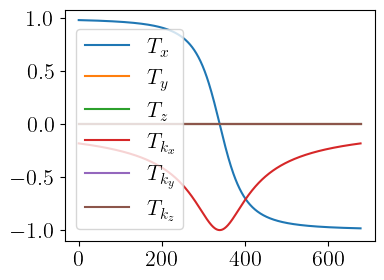

In [15]:
plt.figure(figsize=(4,3))
plt.plot(T[:, 0, 0, :, 0])
plt.legend([r'$T_{x}$', r'$T_{y}$', r'$T_{z}$', r'$T_{k_x}$', r'$T_{k_y}$', r'$T_{k_z}$'])
plt.show()

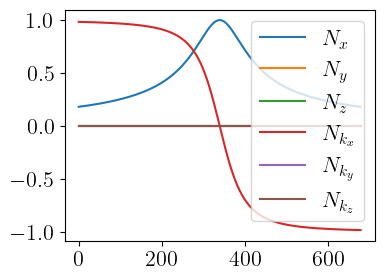

In [16]:
plt.figure(figsize=(4,3))
plt.plot(N[:, 0, 0, :, 0])
plt.legend([r'$N_{x}$', r'$N_{y}$', r'$N_{z}$', r'$N_{k_x}$', r'$N_{k_y}$', r'$N_{k_z}$'])
plt.show()

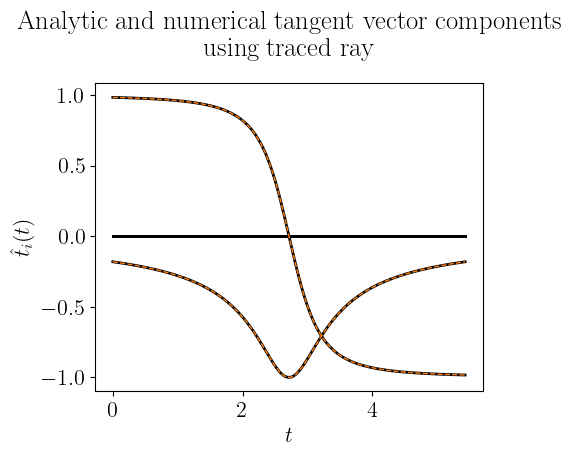

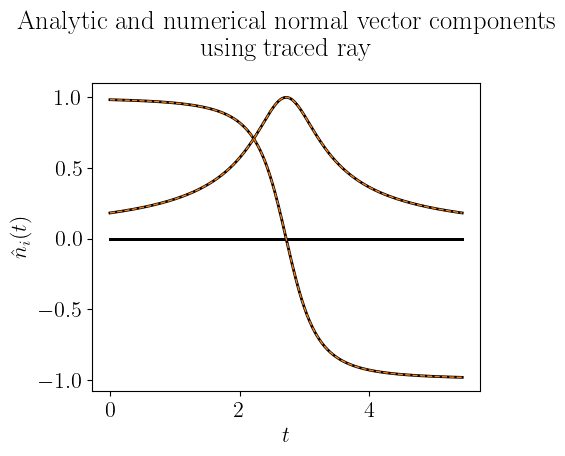

In [17]:
v_ex = np.sqrt(1+4*(ks[..., 0]**2))
T_ex = np.stack([ 1/v_ex * 2*ks[..., 0], -1/v_ex * np.ones_like(ks[..., 0])], axis=-1) # tangent matrix from Lopez example
N_ex = np.stack([ 1/v_ex * np.ones_like(ks[..., 0]), 1/v_ex * 2*ks[..., 0] ], axis=-1)

plt.figure(figsize=(5,4))
plt.plot(t, T[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, T_ex[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{t}_i(t)$')
plt.title('Analytic and numerical tangent vector components \n using traced ray')
plt.show()

plt.figure(figsize=(5,4))
plt.plot(t, N[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, N_ex[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{n}_i(t)$')
plt.title('Analytic and numerical normal vector components \n using traced ray')
plt.show()

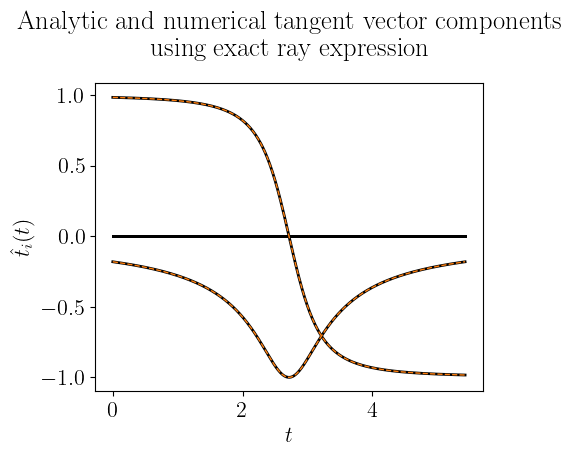

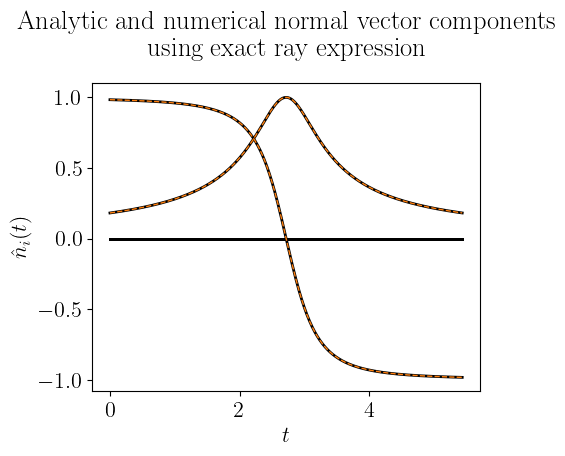

In [18]:
ks_ex = np.apply_along_axis(lambda x: x - t, axis=0, arr=np.ones_like(ks[..., 0]) * ks[0, ..., 0])
v_exx = np.sqrt(1+4*(ks_ex**2))
T_exx = np.stack([ 1/v_ex * 2*ks_ex, -1/v_ex * np.ones_like(ks_ex)], axis=-1) # tangent matrix from Lopez example
N_exx = np.stack([ 1/v_ex * np.ones_like(ks_ex), 1/v_ex * 2*ks_ex], axis=-1)

plt.figure(figsize=(5,4))
plt.plot(t, T[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, T_exx[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{t}_i(t)$')
plt.title('Analytic and numerical tangent vector components \n using exact ray expression')
plt.show()

plt.figure(figsize=(5,4))
plt.plot(t, N[:, 0, 0, :, 0], '-', color='black', linewidth=2, label='approx')
plt.plot(t, N_exx[:, 0, 0, :], '--', color='tab:orange', linewidth=1, label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{n}_i(t)$')
plt.title('Analytic and numerical normal vector components \n using exact ray expression')
plt.show()

In [19]:
# from matplotlib import animation

# fig = plt.figure(figsize=(5,4))
# plt.axis('equal')
# plt.plot(rs[:, 0, 0, 0], ks[:, 0, 0, 0], 'k-')
# plt.xlim(np.min(rs[:, 0, 0, 0]), 0)
# # plt.xlim(-6, 0)
# plt.ylim(-3, 3)
# plt.grid()
# plt.xlabel(r'$x$')
# plt.ylabel(r'$k$')

# t_param = np.linspace(0, 10, 2)

# tangent = plt.plot(rs[0, 0, 0, 0] + T[0, 0, 0, 0, 0] * t_param, ks[0, 0, 0, 0] + T[0, 0, 0, ND, 0] * t_param, '--', color='red')[0]
# normal = plt.plot(rs[0, 0, 0, 0] + N[0, 0, 0, 0, 0] * t_param, ks[0, 0, 0, 0] + N[0, 0, 0, ND, 0] * t_param, '--', color='blue')[0]

# def update(frame):
#     tangent.set_xdata(rs[frame, 0, 0, 0] + T[frame, 0, 0, 0, 0] * t_param)
#     tangent.set_ydata(ks[frame, 0, 0, 0] + T[frame, 0, 0, ND, 0] * t_param)

#     normal.set_xdata(rs[frame, 0, 0, 0] + N[frame, 0, 0, 0, 0] * t_param)
#     normal.set_ydata(ks[frame, 0, 0, 0] + N[frame, 0, 0, ND, 0] * t_param)
#     return tangent, normal

# plt.tight_layout()
# anim = animation.FuncAnimation(fig=fig, func=update, frames=rs.shape[0], blit=True)
# anim.save('./plots/3D_MGO_tangent_animation_nt_' + str(nt) + '.gif', fps=int(rs.shape[0]/20))

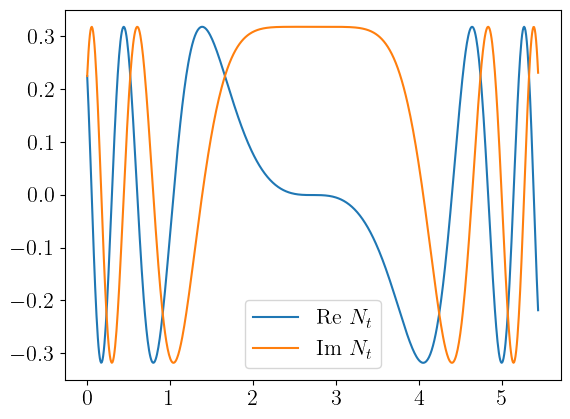

In [20]:
plt.plot(t, np.real(Nt[:, 0, 0]), label=r'Re $N_t$')
plt.plot(t, np.imag(Nt[:, 0, 0]), label=r'Im $N_t$')
plt.legend()

### Geometrical Optics in Transformed Phase Space

In [21]:
def get_branches(J):
    branch_masks = get_masks_of_const_sgn(J, ND=1)
    J_desc = np.argsort(np.abs(J))[::-1]
    seeds = []
    branch_ranges = []
    for branch in branch_masks:
        branch_min, branch_max = np.min(np.argwhere(branch)), np.max(np.argwhere(branch))
        seed = J_desc[(branch_min <= J_desc) & (J_desc <= branch_max)][0]
        seeds.append(seed)
        range_back, range_forward = range(seed, max(branch_min - 1, 0), -1), range(seed, min(branch_max + 1, nt - 1), +1)
        if len(range_back) > 0:
            branch_ranges.append(range_back)
        if len(range_forward) > 0:
            branch_ranges.append(range_forward)
    return branch_masks, seeds, branch_ranges

def neighbourhood(i, N, N_neighbours=1):
    '''returns slice corresponding to neighbourhood of i
        and index of i in sliced array.'''
    if i < 0 or i >= N:
        raise ValueError('index for neighbourhood is out of bounds')
    if i - N_neighbours < 0:
        return slice(min(1+2*N_neighbours, N)), i
    if i + N_neighbours >= N:
        return slice(max(0, N-(1+2*N_neighbours)), N), - (N-i)
    return slice(i - N_neighbours, i + N_neighbours + 1), N_neighbours

def nbh_ij(i, j):
    nbh2, nbh_i2 = neighbourhood(i, n2)
    nbh3, nbh_i3 = neighbourhood(j, n3)
    nbh_slice = np.s_[:, nbh2, nbh3]
    nbh_ind = np.s_[:, nbh_i2, nbh_i3]
    return nbh_slice, nbh_ind

In [22]:
class NDPolynomial():
    def __init__(self, degrees, coeff):
        self.degrees = degrees
        self.coeff = coeff
    
    def __call__(self, x):
        if len(self.degrees) > 0:
            return np.stack([np.prod(x**d, axis=-1) for d in self.degrees], axis=-1) @ self.coeff
        else:
            return np.zeros_like(x)
    
    def _diff(self, axis):
        if len(self.degrees) > 0:
            deriv_degrees = np.array([[d - 1 if i == axis else d for i, d in enumerate(degs)] for degs in self.degrees])
            deriv_coeff = self.degrees[:, axis] * self.coeff
            ind = np.not_equal(np.isclose(deriv_coeff, 0), True)
            return NDPolynomial(deriv_degrees[ind], deriv_coeff[ind])
        else:
            return NDPolynomial([], [])

    def deriv(self, axis, order=1):
        deriv = self
        for i in range(order):
            deriv = deriv._diff(axis=axis)
        return deriv
    
def polyfit(x, y, deg):
    '''Returns NDPolynomial fit of x, y data.
    
    Parameters:
    x: `np.ndarray` of shape (N, M) where N is number of datapoints, M is number of features in x.
    y: `np.ndarray` of shape (N,) where N is number of datapoints
    deg: Either `int` or `np.ndarray`.
        If deg is an `int`, deg is taken to be the highest degree in each variable
        and a monomial basis for the polynomial is generated automatically.
        Alternatively you may provide deg as an array of monomial degrees.
        For example for 3D data (M=3), you can write: `deg = np.array([(0, 0, 0), (0, 1, 0), (0, 0, 2)])`
        to get a function fit of the form f(x1, x2, x3) = a + b * x2 + c * x3**2
    '''
    dims = x.shape[-1]
    if type(deg) == int:
        degrees = np.array(list(product(*(range(deg + 1), )*dims)))
    else:
        degrees = np.array(deg).reshape(-1, x.shape[-1])
    
    monomials = np.stack([np.prod(x**d, axis=-1) for d in degrees], axis=-1)
    coeff = np.linalg.lstsq(monomials, y, rcond=None)[0]
    ind = np.not_equal(np.isclose(coeff, 0), True)
    return NDPolynomial(degrees[ind], coeff[ind])

In [23]:
def start_angles(ddf, eps_0=0):
    alpha = np.angle(ddf(eps_0))
    sigma_p = -np.pi/4 - alpha/2 + np.pi/2
    sigma_m = -np.pi/4 - alpha/2 - np.pi/2
    return sigma_p, sigma_m

def new_angle(f, sigma, r):
    '''Calculate new direction of steepest descent
        as the descent which is closest to current direction, sigma.'''
    C_circ = lambda _r, theta: _r*np.exp(1j*theta)
    F_circ = lambda theta: np.imag(f(C_circ(r, theta)))
    sigmas = np.linspace(0, 2*np.pi, 1000)
    argmaxima = argrelextrema(F_circ(sigmas), np.greater)[0]
    new_sigma = sigmas[argmaxima[np.argmin(np.abs( ((sigma % (2*np.pi)) - sigmas[argmaxima] + np.pi) % (2*np.pi) - np.pi ))]]
    return new_sigma

def get_l_and_s(f, sigma_p, sigma_m, eps_0=0):
    Delta_F = 10

    C_p = lambda l: eps_0 + np.abs(l) * np.exp(1j*sigma_p)
    C_m = lambda l: eps_0 + np.abs(l) * np.exp(1j*sigma_m)

    F_p = lambda l: np.imag(f(C_p(l)))
    F_m = lambda l: np.imag(f(C_m(l)))

    l_p = brentq(lambda l: F_p(l) - F_p(0) - Delta_F, 0, 10)
    l_m = brentq(lambda l: F_m(l) - F_m(0) - Delta_F, 0, 10)
    
    s_p = Delta_F/(np.abs(l_p)**2)
    s_m = Delta_F/(np.abs(l_m)**2)

    return l_p, l_m, s_p, s_m

def get_angles_and_l_and_s(sigma_p, sigma_m, l_p, l_m, s_p, s_m, f, ddf=None, eps_0=0):
    if sigma_p == None or sigma_m == None:
        _sigma_p, _sigma_m = start_angles(ddf, eps_0)
        _l_p, _l_m, _s_p, _s_m = get_l_and_s(f, _sigma_p, _sigma_m, eps_0)
    else:
        _sigma_p = new_angle(f, sigma_p, r=l_p)
        _sigma_m = new_angle(f, sigma_m, r=l_m)
        _l_p, _l_m, _s_p, _s_m = l_p, l_m, s_p, s_m
    return _sigma_p, _sigma_m, _l_p, _l_m, _s_p, _s_m

def integral(f, g, sigma_p, sigma_m, s_p, s_m, eps_0=0):
    sigma_p, sigma_m, s_p, s_m = sigma_p.astype(complex), sigma_m.astype(complex), s_p.astype(complex), s_m.astype(complex)
    h = lambda eps: g(eps) * np.exp(1j*f(eps))
    dl_p, dl_m = np.exp(1j*sigma_p)/np.sqrt(s_p), np.exp(1j*sigma_m)/np.sqrt(s_m)
    I = integrate_gauss_freud_quad(
        lambda l: (h(l*dl_p) * dl_p - h(l*dl_m) * dl_m),
        n = 10,
        dims=len(sigma_p)
    )
    return I

In [24]:
i_caust = np.argmin(np.abs(ks[:, 0, 0, 0]))
t_save = t[i_caust] + np.array([-2.71, -2, -1, -0.3, -0.15, -0.1, -0.05, -0.01, 0, 2.71, 2, 1, 0.3, 0.15, 0.1, 0.05, 0.01])
i_save = [np.argmin(np.abs(t - t0)) for t0 in t_save]

In [25]:
# # Unimplemented Idea: Use first column of U-matrix from SVD decomposition to determine which part of the manifold to rotate, when we wish to have data in more directions.
# # The idea being that the first vector of U tells in which direction B stretches the most.
# # Problem: B represents transformation of k -> X (i.e. X = A x + B k) and trfm. of x -> K (i.e. K = -B x + A k)
# # So how is it related to tau-variables?
# # Naïve approach:
# nbh_window = ((Us[it, i, j, :, 0] * (nt, n2, n3)) / 2).astype(int)
# nbh_window_max = np.array([it, i, j]) + nbh_window
# nbh_window_min = np.array([it, i, j]) - nbh_window

In [26]:
def func_1D(f, axis, input_dims):
    def f_1D(x_1D):
        x_array = np.array(x_1D)
        shape0 = 1 if len(x_array.shape) == 0 else x_array.shape[0]
        X = np.zeros((shape0, input_dims), dtype=x_array.dtype)
        X[..., axis] = x_array
        return f(X)
    return f_1D

In [27]:
from numpy.polynomial.polynomial import Polynomial

results = []
Upsilon = np.zeros((nt, n2, n3), dtype=np.cdouble)

for i, y0 in enumerate(y0s):
    for j, z0 in enumerate(z0s):
        # print('i, j: ', i, j)
        J_ij = np.linalg.det(gradtau_z[:, i, j, :ND])
        branch_masks, seeds, branch_ranges = get_branches(J_ij)
        
        nbh_slice, nbh_ind = nbh_ij(i, j)
        zs_nbh = zs[nbh_slice]
        # zs_nbh = zs[nbh_ij(i, j)]
        for seed, branch_range in zip(seeds, branch_ranges):
            print('branch:', branch_range, end='\r')

            sigma_p, sigma_m, l_p, l_m, s_p, s_m = np.array([None, None, None]), np.array([None, None, None]), np.array([None, None, None]), np.array([None, None, None]), np.array([None, None, None]), np.array([None, None, None])

            for it in branch_range:
                S_t1 = S[it, i, j]
                Xs_nbh = (S_t1[:ND, :] @ zs_nbh[..., np.newaxis]).squeeze()
                gradtau_Xs_nbh = fd.grad(Xs_nbh, t, y0s, z0s, cropped_axes=[1, 2])
                J_t1 = np.linalg.det(gradtau_Xs_nbh)
                mask_t1 = sgn_mask_from_seed(J_t1, (it)) # get current branch
                it1 = int(np.argwhere(t[mask_t1] == t[it]))
                
                Phi_t1 = np.emath.sqrt(J_t1[it]/J_t1[mask_t1]) # Amplitude set to 1 at tau = t1

                gradt_Xs_t1 = gradtau_Xs_nbh[mask_t1, ..., 0]
                Ks_t1 = (S_t1[ND:, :] @ zs[mask_t1, i, j, :, np.newaxis]).squeeze()
                int_0_to_tau = cumulative_trapezoid(np_inner_product(Ks_t1, gradt_Xs_t1), t[mask_t1], initial=0, axis=0)
                Theta_t1 = int_0_to_tau - int_0_to_tau[it1]
                
                rho = ranks[it, i, j]
                a_rho = A_rhos[it, i, j, :rho, :rho]
                Lambda_rho = Lambda_rhos[it, i, j, :rho, :rho]
                Xs_t1 = Xs_nbh[nbh_ind][mask_t1]
                eps_t1 = Xs_t1 - Xs_t1[it1]
                eps_rho = eps_t1[:, :rho]
                Ks_rho = Ks_t1[:, :rho]
                f_t1 = Theta_t1 + (
                        - ((1/2) * np_transpose(eps_rho[..., np.newaxis]) @ a_rho @ np.linalg.inv(Lambda_rho) @ eps_rho[..., np.newaxis]).squeeze()
                        - (np_transpose(eps_rho[..., np.newaxis]) @ Ks_rho[it1, ..., np.newaxis]).squeeze()
                        ).squeeze()
                
                f_fit = polyfit(eps_rho, f_t1, deg=6)

                def g_fit(eps, eps_rho=eps_rho, Phi_t1=Phi_t1):
                    g_tmp_fit = polyfit(eps_rho, np.emath.power(Phi_t1, -4), deg=1)
                    return np.emath.power(g_tmp_fit(eps), -1/4)

                for l in range(rho):
                    f_l = func_1D(f_fit, axis=l, input_dims=rho)
                    ddf_fit = f_fit.deriv(axis=l, order=2)
                    ddf_l = func_1D(ddf_fit, axis=l, input_dims=rho)
                    g_l = func_1D(g_fit, axis=l, input_dims=rho)
                    
                    sigma_p[l], sigma_m[l], l_p[l], l_m[l], s_p[l], s_m[l] = get_angles_and_l_and_s(sigma_p[l], sigma_m[l], l_p[l], l_m[l], s_p[l], s_m[l], f_l, ddf_l)
                if it in i_save and i == 0 and j==0:
                    results.append({'t1': t[it], 'it': it, 'i': i, 'j': j, 'mask_t1': mask_t1, 'it1': it1,
                                    'Xs_t1': Xs_t1, 'Ks_t1': Ks_t1, 'eps_rho': eps_rho,
                                    'sigma_p': np.copy(sigma_p), 'sigma_m': np.copy(sigma_m), 'l_p': np.copy(l_p), 'l_m': np.copy(l_m),
                                    'f_t1': f_t1, 'f_fit': f_fit, 'f_l': f_l, 'Theta_t1': Theta_t1, 'Phi_t1': Phi_t1, 'g_fit': g_fit, 'ddf_fit': ddf_fit})
                Upsilon[it, i, j] = integral(f_fit, g_fit, sigma_p[:rho], sigma_m[:rho], s_p[:rho], s_m[:rho])
        

### Interpolation and Masking

In [28]:
xi = np.linspace(np.min(rs[..., 0])-1, np.max(rs[..., 0])+1, 200)
yi = np.linspace(np.min(rs[..., 1]), np.max(rs[..., 1]), 200)
zi = np.linspace(np.min(rs[..., 2]), np.max(rs[..., 2]), 200)

In [29]:
from scipy.interpolate import RegularGridInterpolator

def get_bins(rs, dim, diff_axis):
    return int((np.max(rs[..., dim]) - np.min(rs[..., dim]))/np.max(np.abs(np.diff(rs[..., dim], axis=diff_axis))))

H, edges = np.histogramdd(rs.reshape(-1,3), bins=(get_bins(rs, 0, 0), get_bins(rs, 1, 1), get_bins(rs, 2, 2)))
centers = [edge[:-1] + np.diff(edge)/2 for edge in edges]
in_region = RegularGridInterpolator(tuple(centers), (H > 0).astype(int), method='nearest', fill_value=0, bounds_error=False)

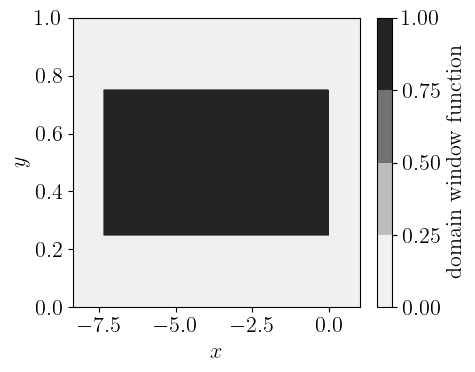

In [30]:
plt.figure(figsize=(5,4))
X, Y = np.meshgrid(xi, yi)
plt.contourf(X, Y, in_region((X, Y, 5*np.ones_like(X))), levels=3, cmap='Greys', vmin=0, vmax=1)
plt.clim(0, 1)
plt.colorbar(label='domain window function')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.tight_layout()
plt.show()

In [31]:
from scipy.interpolate import LinearNDInterpolator


J = np.linalg.det(gradtau_z[..., :ND, :])
# branch_masks, seeds, branch_ranges = get_branches(J)
branch_masks = get_masks_of_const_sgn(J)
branches = [LinearNDInterpolator(rs[mask], Nt[mask] * Upsilon[mask], fill_value=0) for mask in branch_masks]
# # branches = [LinearNDInterpolator(rs[mask], phi[mask]*np.cos(theta[mask]), fill_value=0) for mask in branch_masks if np.sum(mask)>12]

def interp_field_r(r):
    return in_region(r)*sum(f(r) for f in branches)

def interp_field(x, y, z):
    r = np.stack([x, y, z], axis=-1)
    return interp_field_r(r)

A0 = phi1/interp_field_r(np.array([x1, 0.5, 5]))

def E_field_r(r):
    return A0 * interp_field_r(r)

def E_field(x, y, z):
    return A0 * interp_field(x, y, z)

In [32]:
X, Y = np.meshgrid(xi, yi, indexing='ij')
E_XY = E_field(X, Y, 5*np.ones_like(X))

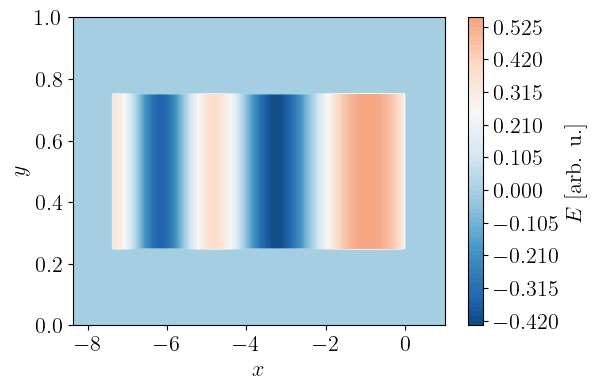

In [33]:
plt.figure(figsize=(6,4))
plt.contourf(X, Y, np.real(E_XY), cmap='RdBu_r', levels=80)
plt.clim(-0.5, 1)
plt.colorbar(label='$E$ [arb. u.]')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.savefig('./plots/3D_MGO_airy_E_field.png')
plt.savefig('./plots/3D_MGO_airy_E_field.pdf')
plt.show()

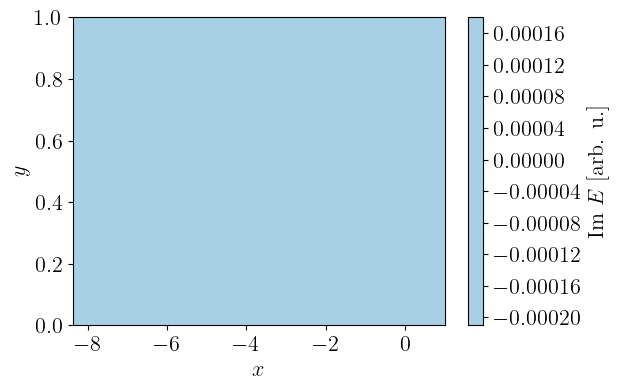

In [34]:
plt.figure(figsize=(6,4))
plt.contourf(X, Y, np.imag(E_XY), cmap='RdBu_r', levels=80)
plt.clim(-0.5, 1)
plt.colorbar(label='Im $E$ [arb. u.]')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.savefig('./plots/3D_MGO_airy_E_Im_field.png')
plt.savefig('./plots/3D_MGO_airy_E_Im_field.pdf')
plt.show()

In [35]:
from scipy.interpolate import interp1d

i_1D, j_1D, dim_1D = 0, 0, 0
branch_masks_1D = [mask[:, i_1D, j_1D] for mask in branch_masks]
branches = [interp1d(rs[mask, i_1D, j_1D, dim_1D], (Nt[mask, i_1D, j_1D] * Upsilon[mask, i_1D, j_1D]), bounds_error=False, fill_value='extrapolate') for mask in branch_masks_1D]

def interp_field_1D(x):
    return sum(f(x) for f in branches)

A0 = phi0/interp_field_1D(x0)

def field_1D(x):
    return A0 * interp_field_1D(x)

(-0.5, 1.0)

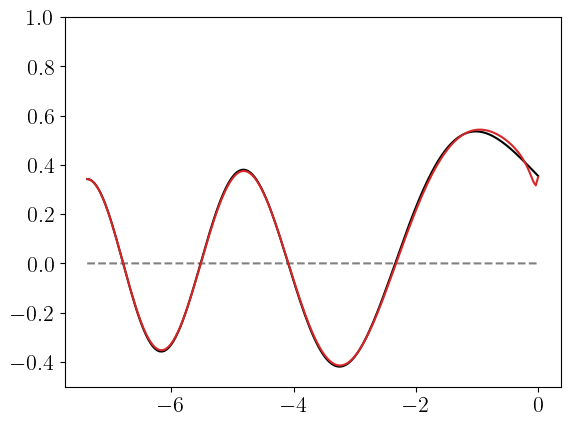

In [36]:
xi = np.linspace(np.min(rs[:, 0, 0, 0]), np.max(rs[:, 0, 0, 0]), 200)
plt.plot(xi, np.imag(field_1D(xi)), '--', color='grey', label='imag sum')
plt.plot(xi, Ai(xi), color='black', label='exact')
plt.plot(xi, np.real(field_1D(xi)), '-', label='real sum', color='tab:red')
plt.ylim(-0.5, 1)

### Inspect Results

#### Complex Phase Plots

In [37]:
# Define analytical functions for comparison with numerical results
v_anal = lambda p: np.sqrt(1+4*(p**2))
f_anal = lambda eps, p: (
    (v_anal(p)**6 - (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(3/2))/(96*(p**3))
    - v_anal(p)**3/(8*(p**2)) * eps + v_anal(p)**2/(4*p) * eps**2
    )
df_anal = lambda eps, p: v_anal(p)/(8*(p**2)) * (
    4*v_anal(p)*p*eps
    - v_anal(p)**2
    + (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(1/2)
    )
ddf_anal = lambda eps, p: v_anal(p)**2/(2*p) * (1 - (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(-1/2)) 
g_anal = lambda eps, p: (1/(2*np.pi)) * v_anal(p)/(v_anal(p)**4 - 8*v_anal(p)*p*eps)**(1/4)

In [38]:
C = lambda l, sigma_p, sigma_m: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: np.exp(1j*sigma_m), lambda l: np.exp(1j*sigma_p)])
C_R = lambda l, sigma_p, sigma_m: np.real(C(l, sigma_p, sigma_m))
C_I = lambda l, sigma_p, sigma_m: np.imag(C(l, sigma_p, sigma_m))

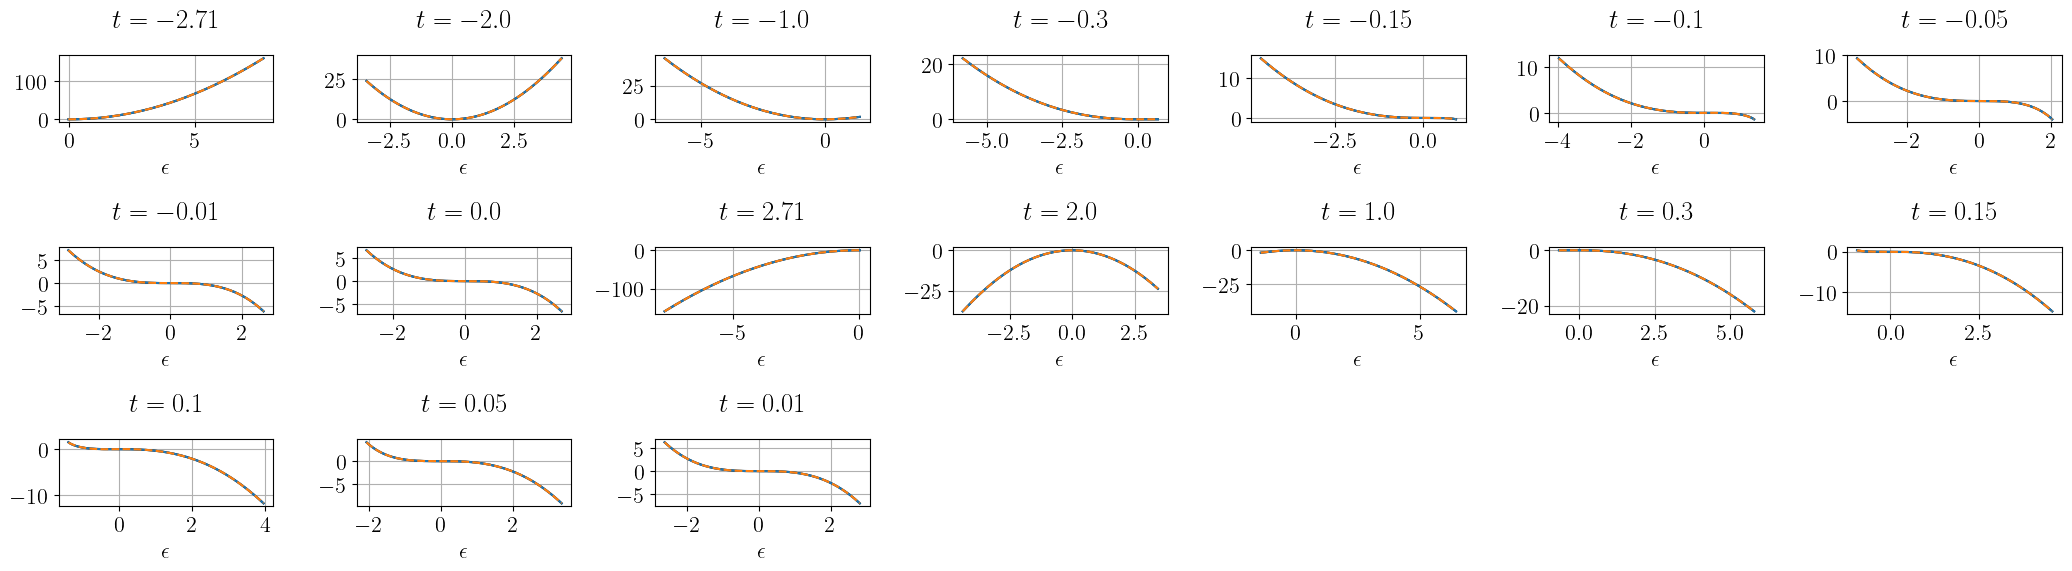

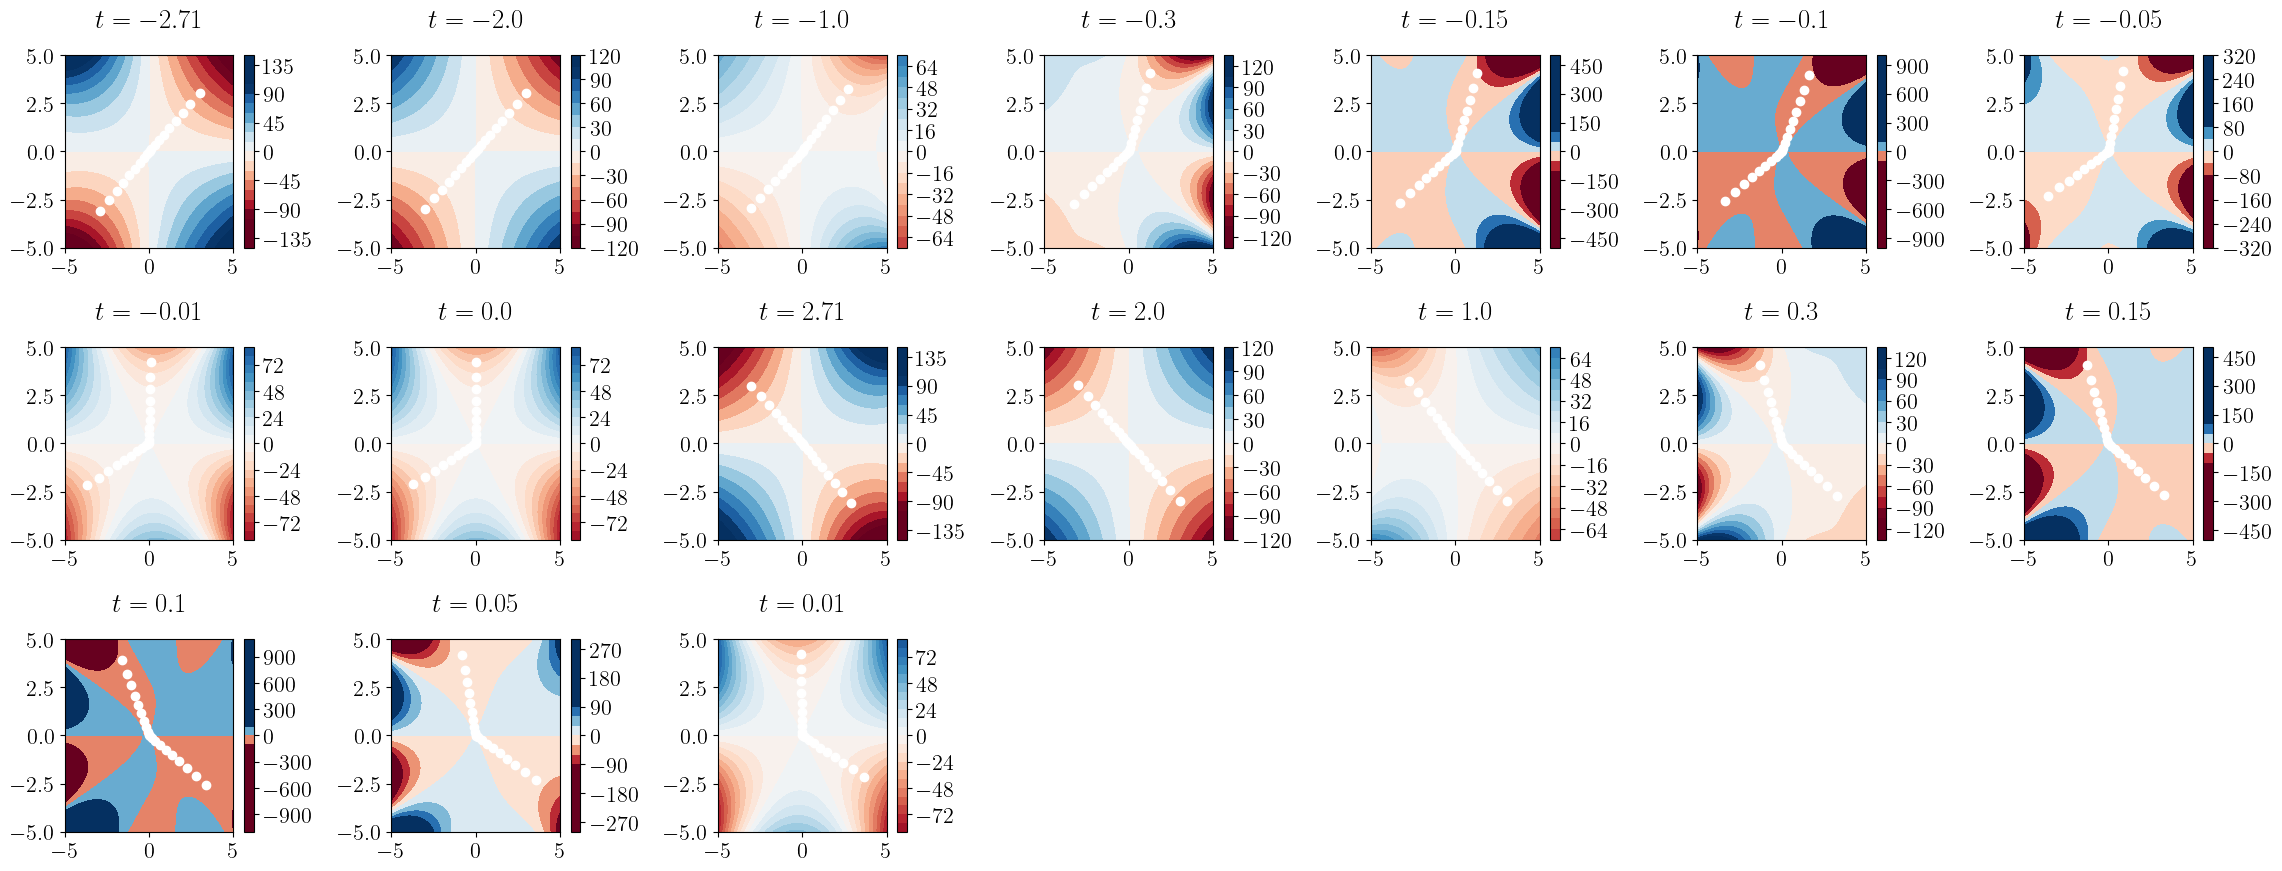

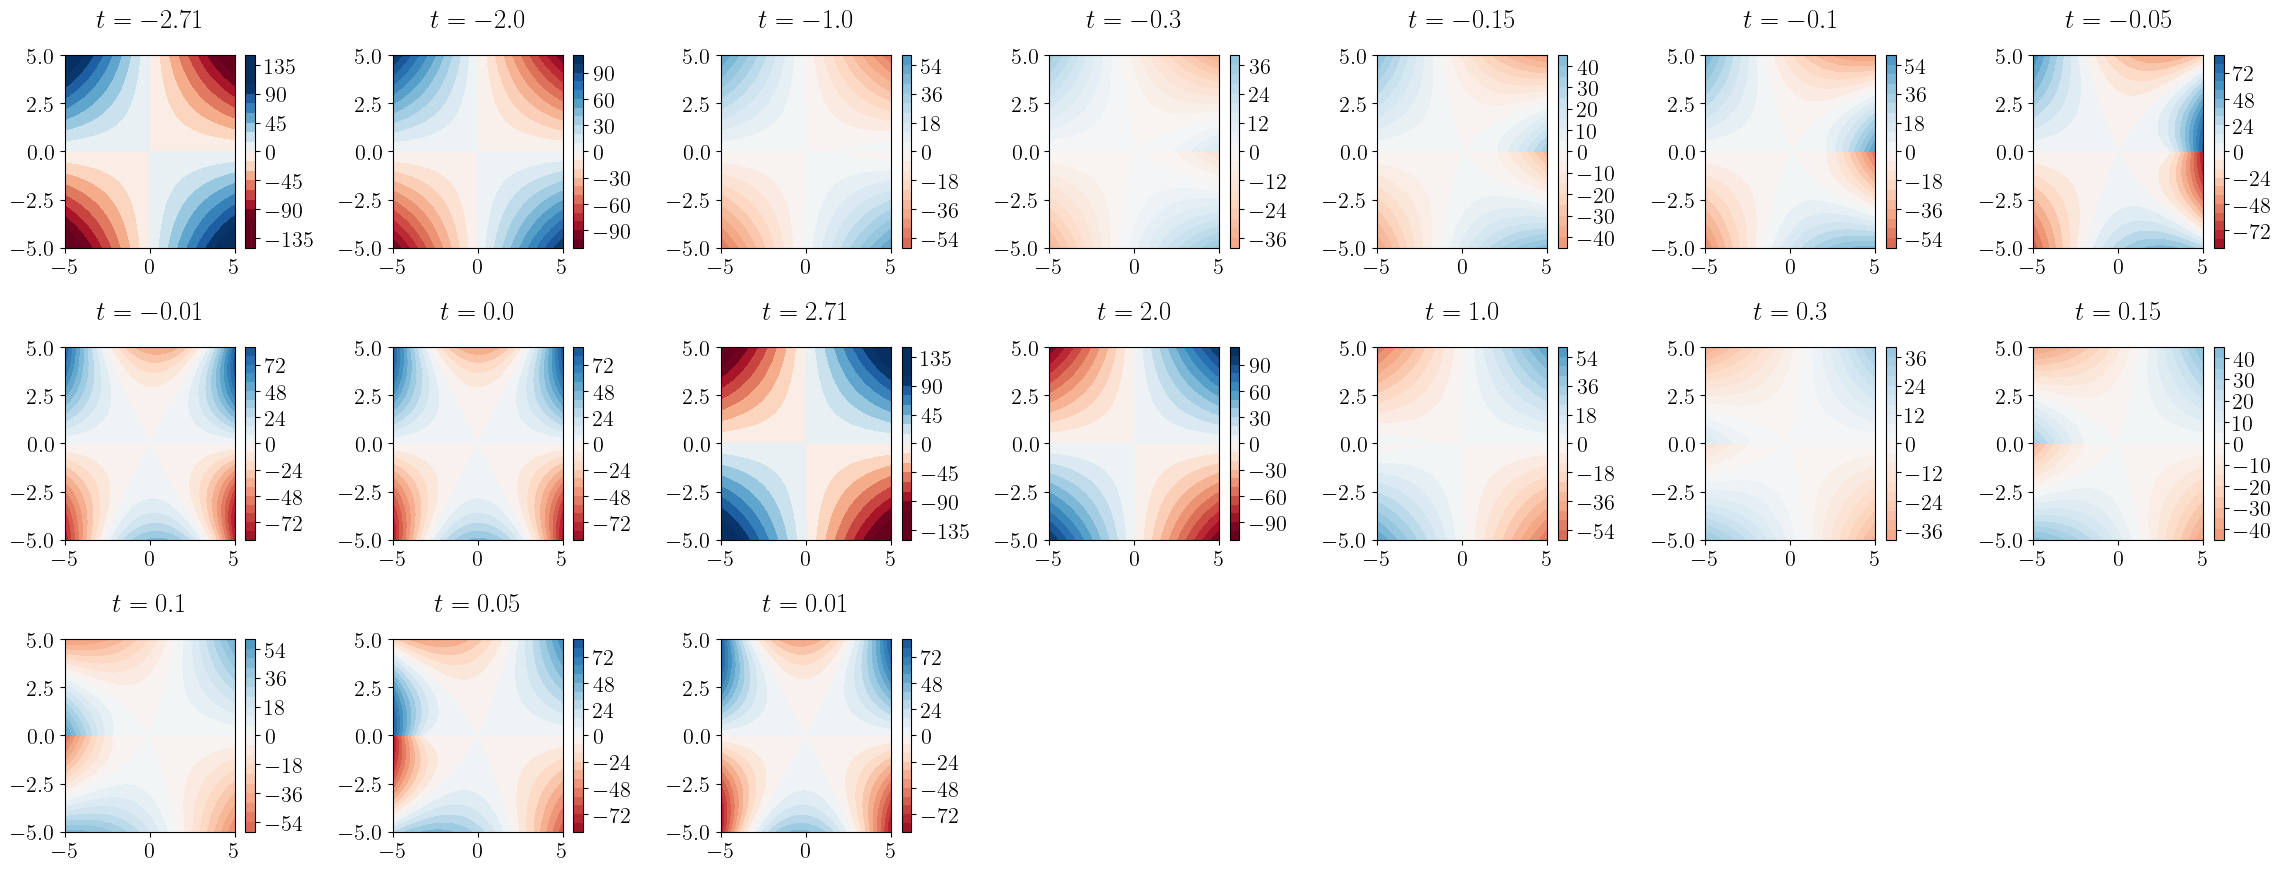

In [39]:
eps_R = np.linspace(-5,5, 1000)
eps_I = np.linspace(-5,5, 1000)
Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
Eps = Eps_R + 1j*Eps_I
l_j, _ = get_nodes_and_weights(n=10)
l_j = l_j.astype(np.complex_)

ncols, nrows = 7, 3
fig = plt.figure(1, figsize=(ncols*3,nrows*2))
fig2 = plt.figure(2, figsize=(ncols*3.3,nrows*3))
fig3 = plt.figure(3, figsize=(ncols*3.3,nrows*3))

for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig.add_subplot(nrows, ncols, 1 + i)
    t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    k = ks[it, 0, 0, 0]
    ax.plot(eps_rho, f_t1, 'k-')
    ax.plot(eps_rho, f_anal(eps_rho, k), '-', color='tab:blue')
    ax.plot(eps_rho, f_fit(eps_rho), '--', color='tab:orange')
    # ax.plot(eps_rho, f_t1 - f_fit(eps_rho).squeeze(), '-', color='tab:red')
    ax.set_title('$t = ' + str(np.round(t1 - t[i_caust],2)) + '$')
    ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig.tight_layout()


for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig2.add_subplot(nrows, ncols, 1 + i)
    t1, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
    contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape)), cmap='RdBu', levels=20, vmin=-100, vmax=100)
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title('$t = ' + str(np.round(t1 - t[i_caust],2)) + '$')
    # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

    # Plot node points along integral path
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0]), C_I(-l_j, sigma_p[0], sigma_m[0]), 'ow')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0]), C_I(l_j, sigma_p[0], sigma_m[0]), 'ow')
fig2.tight_layout()

for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig3.add_subplot(nrows, ncols, 1 + i)
    t1, it = (result[key] for key in ['t1', 'it'])
    k = ks[it, 0, 0, 0]
    contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_anal(Eps, k)), cmap='RdBu', levels=20, vmin=-100, vmax=100)
    fig.colorbar(contour_plot, ax=ax)
    ax.set_title('$t = ' + str(np.round(t1 - t[i_caust], 2)) + '$')
    # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
    # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')
fig3.tight_layout()

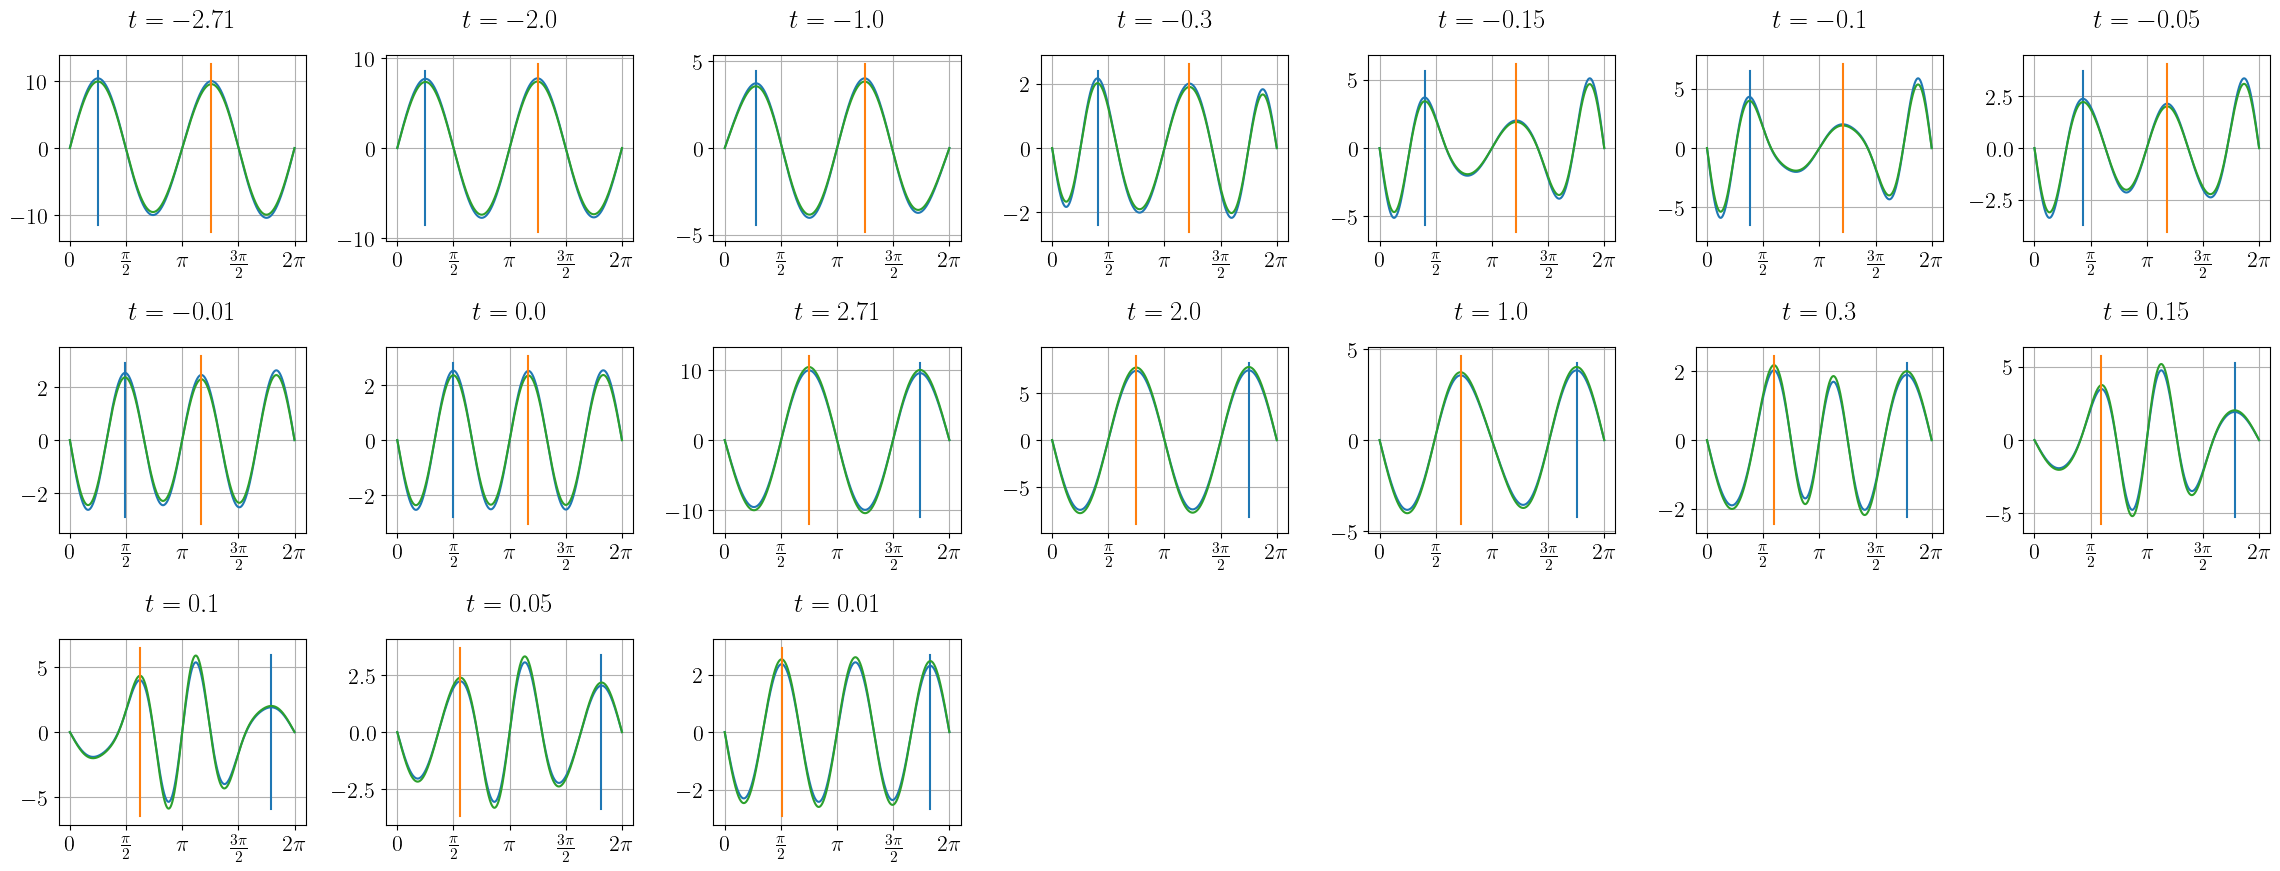

In [40]:
fig4 = plt.figure(4, figsize=(ncols*3.3,nrows*3))

sigmas = np.linspace(0, 2*np.pi, 1000)
C_circ = lambda _r, theta: _r*np.exp(1j*theta)
for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    ax = fig4.add_subplot(nrows, ncols, 1 + i)
    t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m, l_p, l_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m', 'l_p', 'l_m'])  
    F_circ_m = lambda theta: np.imag(f_fit(C_circ(l_m[0], theta).reshape(-1, 1)))
    F_circ_p = lambda theta: np.imag(f_fit(C_circ(l_p[0], theta).reshape(-1, 1)))
    ax.plot(sigmas, F_circ_m(sigmas), color='tab:blue')
    ax.plot([sigma_p[0] % (2*np.pi), sigma_p[0]% (2*np.pi)], ax.get_ylim())
    ax.plot(sigmas, F_circ_p(sigmas), color='tab:green')
    ax.plot([sigma_m[0]% (2*np.pi), sigma_m[0] % (2*np.pi)], ax.get_ylim())
    ax.set_xticks(np.array([0, 1/2, 1, 3/2, 2])*np.pi, labels=[r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2 \pi$'])
    # ax.plot(eps_rho, f_t1 - f_fit(eps_rho).squeeze(), '-', color='tab:red')
    ax.set_title('$t = ' + str(np.round(t1 - t[i_caust],2)) + '$')
    # ax.set_xlabel(r'$\epsilon$')
    ax.grid()
fig4.tight_layout()

In [44]:
# Define analytical functions for comparison with numerical results
v_anal = lambda p: np.sqrt(1+4*(p**2))
f_anal = lambda eps, p: (
    (v_anal(p)**6 - (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(3/2))/(96*(p**3))
    - v_anal(p)**3/(8*(p**2)) * eps + v_anal(p)**2/(4*p) * eps**2
    )
df_anal = lambda eps, p: v_anal(p)/(8*(p**2)) * (
    4*v_anal(p)*p*eps
    - v_anal(p)**2
    + (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(1/2)
    )
ddf_anal = lambda eps, p: v_anal(p)**2/(2*p) * (1 - (v_anal(p)**4 - 8*v_anal(p)*p*eps)**(-1/2)) 
g_anal = lambda eps, p: (1/(2*np.pi)) * v_anal(p)/(v_anal(p)**4 - 8*v_anal(p)*p*eps)**(1/4)

In [45]:
def get_exact_qtys(i_result):
    it, eps_rho = (results[i_result][key] for key in ['it', 'eps_rho'])
    eps_rho = eps_rho.squeeze()
    k = ks[it, 0, 0, 0]
    beta_t_ex_t1 = k**5/(v_anal(k)**2)
    gamma_ex_t1 = ((k**2)/v_anal(k)) * eps_rho - k * (eps_rho**2)
    Theta_ex_t1 = (
        (8*(k**4) - (v_anal(k)**4))
        / (8*(k**2) * v_anal(k)) * eps_rho
        + (1/(4*k)) * (eps_rho **2)
        + ((v_anal(k)**6) - (v_anal(k)**4 - 8 * k * v_anal(k) * eps_rho)**(3/2))
        / (96*(k**3))
        )

    # f_ex_t1 = k*(eps_t1**2) - (eps_t1**3)/(3*(v_ex[it]**3))
    f_ex_t1 = Theta_ex_t1 - gamma_ex_t1
    f_ex_t1_2 = ((v_anal(k)**6 - (v_anal(k)**4 - 8*v_anal(k)*k*eps_rho)**(3/2)) / ( 96 * k**3 )
            - v_anal(k)**3/(8*(k**2)) * eps_rho + (v_anal(k)**2)/(4*k) * eps_rho**2
            )

    Phi_ex_t1 = v_anal(k)/((v_anal(k)**4 - 8 * v_anal(k) * k * eps_rho)**(1/4))

    Field_ex_t1 = Phi_ex_t1*np.exp(1j*Theta_ex_t1)

    return beta_t_ex_t1, gamma_ex_t1, Theta_ex_t1, f_ex_t1, Phi_ex_t1, Field_ex_t1

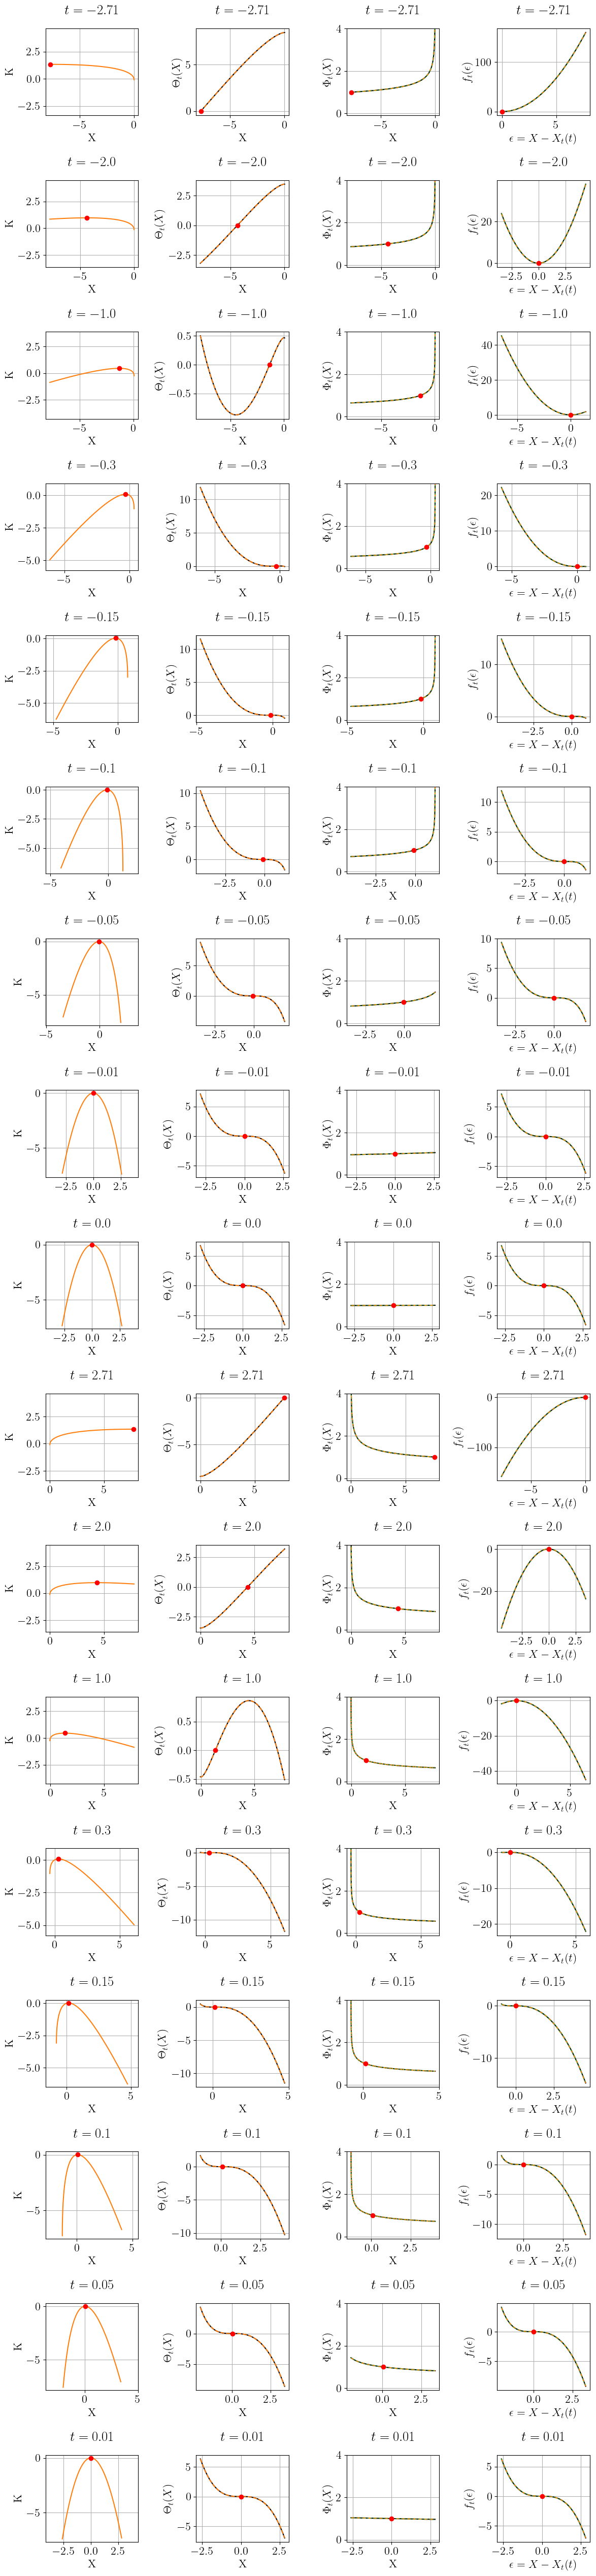

In [46]:
nrows, ncols = len(results), 4

fig = plt.figure(figsize=(ncols*3,nrows*3))

for i, result in enumerate(results):
    # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
    it1, t1, Xs_t1, Ks_t1, mask_t1, eps_rho, Theta_t1, Phi_t1, f_t1, f_fit, g_fit = (result[key] for key in ['it1', 't1', 'Xs_t1', 'Ks_t1', 'mask_t1', 'eps_rho', 'Theta_t1', 'Phi_t1', 'f_t1', 'f_fit', 'g_fit'])
    beta_t_ex_t1, gamma_ex_t1, Theta_ex_t1, f_ex_t1, Phi_ex_t1, Field_ex_t1 = get_exact_qtys(i)
    
    ax = fig.add_subplot(nrows, ncols, (1+ncols*i) + 0)
    ax.axis('equal')
    ax.set_title(r'$t = ' + str(np.round(t1 - t[i_caust],2)) +  '$')
    ax.plot(Xs_t1[:, 0], Ks_t1[:, 0], color='tab:orange')
    ax.plot(Xs_t1[it1, 0], Ks_t1[it1, 0], 'ro')
    ax.grid()
    ax.set_xlabel('X')
    ax.set_ylabel('K')

    ax = fig.add_subplot(nrows, ncols, (1+ncols*i) + 1)
    ax.set_title(r'$t = ' + str(np.round(t1 - t[i_caust],2)) +  '$')
    # ax.plot(Xs_t0[mask_t0], Theta_ex_t0[mask_t0], 'k-')
    ax.plot(Xs_t1[:, 0], Theta_ex_t1, 'k-')
    ax.plot(Xs_t1[:, 0], Theta_t1, '--', color='tab:orange')
    ax.plot(Xs_t1[it1, 0], Theta_t1[it1], 'ro')
    ax.grid()
    ax.set_xlabel('X')
    ax.set_ylabel(r'$\Theta_t(X)$')

    ax = fig.add_subplot(nrows, ncols, (1+ncols*i) + 2)
    ax.set_title(r'$t = ' + str(np.round(t1 - t[i_caust],2)) +  '$')
    ax.plot(Xs_t1[:, 0], Phi_ex_t1, 'k-')
    ax.plot(Xs_t1[:, 0], Phi_t1, '--', color='tab:orange')
    ax.plot(Xs_t1[:, 0], g_fit(eps_rho), ':', color='tab:green')
    ax.plot(Xs_t1[it1, 0], Phi_t1[it1], 'ro')
    ax.set_ylim(-0.1, 4)
    ax.grid()
    ax.set_xlabel('X')
    ax.set_ylabel(r'$\Phi_t(X)$')

    ax = fig.add_subplot(nrows, ncols, (1+ncols*i) + 3)
    ax.set_title(r'$t = ' + str(np.round(t1 - t[i_caust],2)) +  '$')
    ax.plot(eps_rho, f_ex_t1, 'k-')
    ax.plot(eps_rho, f_t1, '--', color='tab:orange')
    ax.plot(eps_rho, f_fit(eps_rho), ':', color='tab:green')
    ax.plot(eps_rho[it1], f_t1[it1], 'ro')
    ax.set_xlabel(r'$\epsilon = X - X_t(t)$')
    ax.set_ylabel(r'$f_t(\epsilon)$')
    ax.grid()

#     print('err on beta at t = ' + str(np.round(t0 - t[i_caust],2)) +  ': ', np.round(np.abs(beta_t_ex_t0 - beta_t[it]), 4), end='\r')

fig.tight_layout()